In [2]:
# Cell 1/11 — Install & Imports
!nvidia-smi
!pip install --quiet obspy xgboost joblib gdown tqdm seaborn matplotlib pandas numpy scikit-learn

import os, random, datetime, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import display, HTML

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import xgboost as xgb
import joblib
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.trigger import classic_sta_lta, trigger_onset

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

print("✅ Imports complete. Ready to run the pipeline.")


Tue Oct 28 01:39:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Cell 2/11 — Seed + constants
import torch

def set_seed(seed=4):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    try:
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass
    os.environ['PYTHONHASHSEED'] = str(seed)
    try:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except Exception:
        pass

set_seed(4)
print("✅ Seed set to 4 for reproducibility.")

# Paths & constants
FILE_ID = "1a8XaGByqoz9xmpsFylUf7HXXAfOx8Aj2"   # dataset file id (same as your original)
DATA_FILENAME = "EEW_features_2024-10-21.csv"
GDRIVE_URL = f"https://drive.google.com/uc?id={FILE_ID}"
MODEL_OUT = "/content/xgb_eew_final.joblib"
PREPROC_OUT = "/content/preproc_objects.joblib"

p_wave_features = [
    'pkev12','pkev23','durP','tauPd','tauPt',
    'PDd','PVd','PAd','PDt','PVt','PAt',
    'ddt_PDd','ddt_PVd','ddt_PAd','ddt_PDt','ddt_PVt','ddt_PAt'
]

print("✅ Constants defined. P-wave feature list length:", len(p_wave_features))


✅ Seed set to 4 for reproducibility.
✅ Constants defined. P-wave feature list length: 17


In [4]:
# Cell 3/11 — Download dataset and initial cleaning
import gdown
print("Downloading dataset...")
gdown.download(GDRIVE_URL, DATA_FILENAME, quiet=False)

# Attempt to read with skiprows=[1] (keeps your original)
try:
    df = pd.read_csv(DATA_FILENAME, skiprows=[1])
except Exception:
    df = pd.read_csv(DATA_FILENAME)

# Strip column names and coerce numeric where applicable
df.columns = df.columns.str.strip()
for col in df.columns:
    if col not in ['filename', 'date', 'time']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill numeric NaNs with median
df = df.fillna(df.median(numeric_only=True))

# Keep only rows where all required p-wave features are > 0
df_before = len(df)
df = df[(df[p_wave_features] > 0).all(axis=1)]
df_after = len(df)

print(f"Dataset loaded. Rows before filter: {df_before}, after filter: {df_after}")
display(df.head(3))


Downloading...
From: https://drive.google.com/uc?id=1a8XaGByqoz9xmpsFylUf7HXXAfOx8Aj2
To: /content/EEW_features_2024-10-21.csv
100%|██████████| 6.82M/6.82M [00:00<00:00, 34.1MB/s]


Dataset loaded. Rows before filter: 25436, after filter: 21687


,filename,date,time,Rmag,Rdpth,Rlat,Rlon,Station,Sheight,Slat,...,ddt_PDd,ddt_PVd,ddt_PAd,ddt_PDt,ddt_PVt,ddt_PAt,PGA,PGV,tPGA,tPGV
0,'HKD0540001282321.EW',2000/01/28,23:21:00,6.8,56,42.983,146.711,NaN,63.0,43.7996,...,0.00637,0.08890,0.69803,0.04389,0.21261,1.91145,26.949,7.176,32.19,31.36
1,'HKD0550001282321.EW',2000/01/28,23:21:00,6.8,56,42.983,146.711,NaN,23.0,43.8244,...,0.00554,0.05553,1.18973,0.05951,0.39105,6.53578,60.838,8.211,30.04,30.43
2,'HKD0590001282321.EW',2000/01/28,23:21:00,6.8,56,42.983,146.711,NaN,30.0,43.8569,...,0.02187,0.09294,1.50502,0.07332,0.26394,7.50573,108.173,17.529,28.40,31.00


Splits created:
  Train: 17349 Validation: 2169 Test: 2169


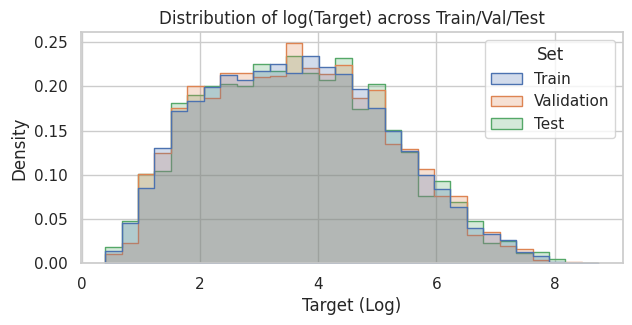

In [5]:
# Cell 4/11 — Prepare X, y and stratified splits (same as your original)
X = df[p_wave_features].copy()
y_raw = df['PGA'].copy()
X = np.log1p(X)        # training used log1p on features
y_log = np.log1p(y_raw) # training used log1p on target

# Stratified splits using qcut bins (replicates your approach)
y_bins = pd.qcut(y_log, q=10, labels=False, duplicates='drop')
sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, temp_idx = next(sss1.split(X, y_bins))
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
val_idx, test_idx = next(sss2.split(X.iloc[temp_idx], y_bins.iloc[temp_idx]))
val_idx, test_idx = temp_idx[val_idx], temp_idx[test_idx]

X_train, X_val, X_test = X.iloc[train_idx], X.iloc[val_idx], X.iloc[test_idx]
y_train_log, y_val_log, y_test_log = y_log.iloc[train_idx], y_log.iloc[val_idx], y_log.iloc[test_idx]
y_train_raw, y_val_raw, y_test_raw = y_raw.iloc[train_idx], y_raw.iloc[val_idx], y_raw.iloc[test_idx]

print("Splits created:")
print("  Train:", len(X_train), "Validation:", len(X_val), "Test:", len(X_test))

# Plot the target (log) distribution across splits
plot_df = pd.DataFrame({
    'Target (Log)': pd.concat([y_train_log, y_val_log, y_test_log], axis=0),
    'Set': ['Train']*len(y_train_log) + ['Validation']*len(y_val_log) + ['Test']*len(y_test_log)
})
plt.figure(figsize=(7,3))
sns.histplot(data=plot_df, x='Target (Log)', hue='Set', element='step', stat='density', common_norm=False, bins=30)
plt.title('Distribution of log(Target) across Train/Val/Test')
plt.show()


In [6]:
# Cell 5/11 — Preprocessing: scaler, imputer, selector
scaler = RobustScaler().fit(X_train)
imputer = SimpleImputer(strategy='mean').fit(X_train)
selector = SelectKBest(score_func=f_regression, k='all').fit(X_train, y_train_log)

X_train_sel = selector.transform(imputer.transform(scaler.transform(X_train)))
X_val_sel   = selector.transform(imputer.transform(scaler.transform(X_val)))
X_test_sel  = selector.transform(imputer.transform(scaler.transform(X_test)))

print("Preprocessing fitted on train. Transformed shapes:")
print("  X_train_sel:", X_train_sel.shape)
print("  X_val_sel  :", X_val_sel.shape)
print("  X_test_sel :", X_test_sel.shape)


Preprocessing fitted on train. Transformed shapes:
  X_train_sel: (17349, 17)
  X_val_sel  : (2169, 17)
  X_test_sel : (2169, 17)


In [8]:
# Cell 6/11 — Train final XGBoost using your best hyperparameters (NO Optuna)
best_params = {'n_estimators': 776, 'learning_rate': 0.010590433420511285, 'max_depth': 6, 'subsample': 0.666852461341688, 'colsample_bytree': 0.8724127328229327}


print("Training final XGBoost with best_params:", best_params)
final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=int(best_params['n_estimators']),
    learning_rate=float(best_params['learning_rate']),
    max_depth=int(best_params['max_depth']),
    subsample=float(best_params['subsample']),
    colsample_bytree=float(best_params['colsample_bytree']),
    random_state=42,
    verbosity=0,
    tree_method='auto'
)

final_model.fit(X_train_sel, y_train_log)
print("✅ Model trained.")


Training final XGBoost with best_params: {'n_estimators': 776, 'learning_rate': 0.010590433420511285, 'max_depth': 6, 'subsample': 0.666852461341688, 'colsample_bytree': 0.8724127328229327}
✅ Model trained.


In [9]:
# Cell 7/11 — Evaluate and save
def evaluate_model(model, X_sel, y_log, y_raw):
    preds_log = model.predict(X_sel)
    preds_raw = np.expm1(preds_log)
    return {
        'log': {
            'R2': r2_score(y_log, preds_log),
            'MAE': mean_absolute_error(y_log, preds_log),
            'RMSE': np.sqrt(mean_squared_error(y_log, preds_log))
        },
        'raw': {
            'R2': r2_score(y_raw, preds_raw),
            'MAE': mean_absolute_error(y_raw, preds_raw),
            'RMSE': np.sqrt(mean_squared_error(y_raw, preds_raw))
        }
    }

val_metrics = evaluate_model(final_model, X_val_sel, y_val_log, y_val_raw)
test_metrics = evaluate_model(final_model, X_test_sel, y_test_log, y_test_raw)

print("Validation metrics (log):", val_metrics['log'])
print("Validation metrics (raw):", val_metrics['raw'])
print("Test metrics (log):", test_metrics['log'])
print("Test metrics (raw):", test_metrics['raw'])

# Save model + preprocessing objects for later reuse
joblib.dump(final_model, MODEL_OUT)
joblib.dump({'scaler': scaler, 'imputer': imputer, 'selector': selector, 'p_wave_features': p_wave_features}, PREPROC_OUT)
print(f"Saved final model -> {MODEL_OUT}")
print(f"Saved preprocessing objects -> {PREPROC_OUT}")


Validation metrics (log): {'R2': 0.8446875603462218, 'MAE': 0.46005247439597435, 'RMSE': np.float64(0.5948434349023727)}
Validation metrics (raw): {'R2': 0.7795878899647536, 'MAE': 45.705211974487376, 'RMSE': np.float64(115.65894200115072)}
Test metrics (log): {'R2': 0.8512164467788745, 'MAE': 0.46260762528693766, 'RMSE': np.float64(0.5942653260775058)}
Test metrics (raw): {'R2': 0.7739583217699366, 'MAE': 49.600511436998815, 'RMSE': np.float64(131.55394118160524)}
Saved final model -> /content/xgb_eew_final.joblib
Saved preprocessing objects -> /content/preproc_objects.joblib


,R2,MAE,RMSE
Train,0.883800,0.406510,0.520045
Validation,0.844700,0.460052,0.594843
Test,0.851200,0.462608,0.594265


,R2,MAE,RMSE
Train,0.807400,42.483300,114.954619
Validation,0.779600,45.705212,115.658942
Test,0.774000,49.600511,131.553941


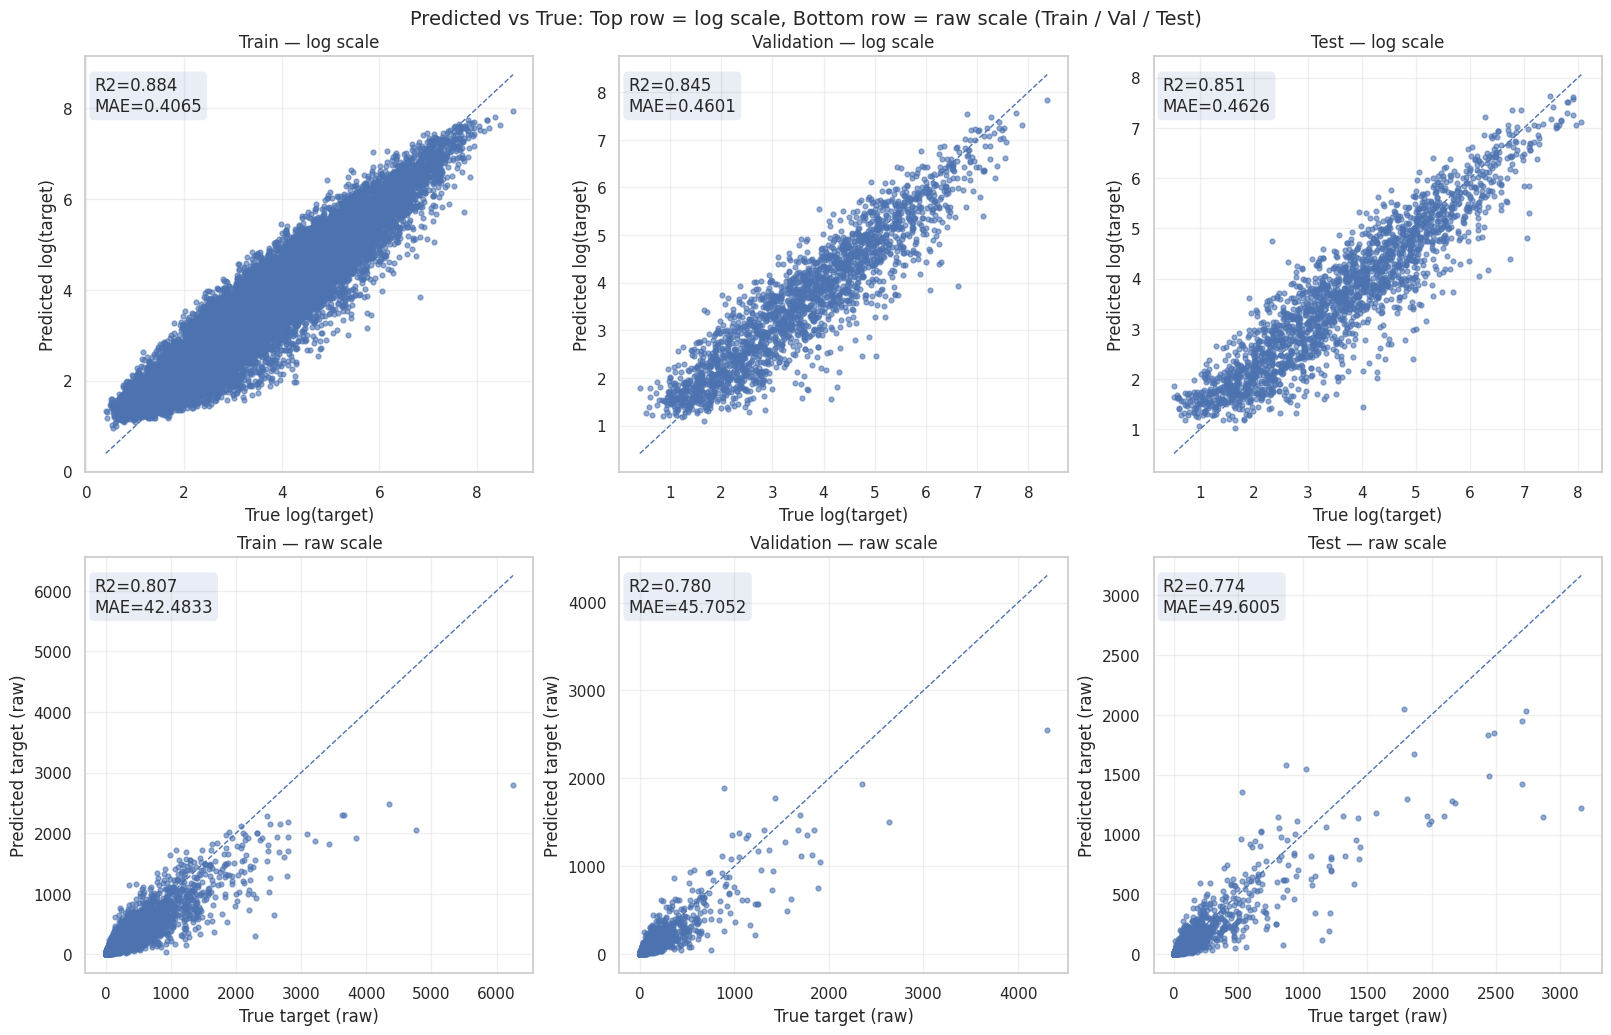

Saved Pred vs True figure -> /content/pred_vs_true_log_and_raw.png


In [10]:
# Cell 7 (REPLACEMENT) — Evaluate, display metrics (log & raw) in tables, and plot Predicted vs True (2 rows × 3 cols)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def compute_metrics(y_true, y_pred):
    """Return dict of R2, MAE, RMSE for given true and predicted arrays."""
    return {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }

# --- Predictions (log scale) ---
pred_train_log = final_model.predict(X_train_sel)
pred_val_log   = final_model.predict(X_val_sel)
pred_test_log  = final_model.predict(X_test_sel)

# --- Convert to raw scale ---
pred_train_raw = np.expm1(pred_train_log)
pred_val_raw   = np.expm1(pred_val_log)
pred_test_raw  = np.expm1(pred_test_log)

# --- Compute metrics for log and raw (train/val/test) ---
metrics_log = {
    'Train': compute_metrics(y_train_log.values, pred_train_log),
    'Validation': compute_metrics(y_val_log.values, pred_val_log),
    'Test': compute_metrics(y_test_log.values, pred_test_log)
}

metrics_raw = {
    'Train': compute_metrics(y_train_raw.values, pred_train_raw),
    'Validation': compute_metrics(y_val_raw.values, pred_val_raw),
    'Test': compute_metrics(y_test_raw.values, pred_test_raw)
}

# --- Build formatted DataFrames for display ---
metrics_log_df = pd.DataFrame(metrics_log).T[['R2','MAE','RMSE']]
metrics_raw_df = pd.DataFrame(metrics_raw).T[['R2','MAE','RMSE']]

# Round for neat display
metrics_log_df = metrics_log_df.round({'R2':4, 'MAE':6, 'RMSE':6})
metrics_raw_df = metrics_raw_df.round({'R2':4, 'MAE':6, 'RMSE':6})

# Display side-by-side
display(HTML("<h3>Model performance — Log scale</h3>"))
display(metrics_log_df.style.set_caption("Metrics on log(target)"))

display(HTML("<h3>Model performance — Raw (original) scale</h3>"))
display(metrics_raw_df.style.set_caption("Metrics on raw target"))

# --- Create Predicted vs True plots ---
sets = [
    ('Train', y_train_log.values, pred_train_log, y_train_raw.values, pred_train_raw),
    ('Validation', y_val_log.values, pred_val_log, y_val_raw.values, pred_val_raw),
    ('Test', y_test_log.values, pred_test_log, y_test_raw.values, pred_test_raw)
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10), constrained_layout=True)

for col, (name, y_log_true, y_log_pred, y_raw_true, y_raw_pred) in enumerate(sets):
    # Top row: log
    ax = axes[0, col]
    ax.scatter(y_log_true, y_log_pred, s=12, alpha=0.6)
    # 1:1 line
    mn = min(np.nanmin(y_log_true), np.nanmin(y_log_pred))
    mx = max(np.nanmax(y_log_true), np.nanmax(y_log_pred))
    ax.plot([mn, mx], [mn, mx], linestyle='--', linewidth=1)
    ax.set_title(f"{name} — log scale")
    ax.set_xlabel("True log(target)")
    ax.set_ylabel("Predicted log(target)")
    ax.grid(True, alpha=0.3)

    # Add simple bias/dispersion annotation
    r2 = compute_metrics(y_log_true, y_log_pred)['R2']
    mae = compute_metrics(y_log_true, y_log_pred)['MAE']
    ax.annotate(f"R2={r2:.3f}\nMAE={mae:.4f}", xy=(0.02, 0.95), xycoords='axes fraction',
                ha='left', va='top', bbox=dict(boxstyle='round', alpha=0.12))

    # Bottom row: raw (original) scale
    ax2 = axes[1, col]
    ax2.scatter(y_raw_true, y_raw_pred, s=12, alpha=0.6)
    mn2 = min(np.nanmin(y_raw_true), np.nanmin(y_raw_pred))
    mx2 = max(np.nanmax(y_raw_true), np.nanmax(y_raw_pred))
    ax2.plot([mn2, mx2], [mn2, mx2], linestyle='--', linewidth=1)
    ax2.set_title(f"{name} — raw scale")
    ax2.set_xlabel("True target (raw)")
    ax2.set_ylabel("Predicted target (raw)")
    ax2.grid(True, alpha=0.3)

    r2_raw = compute_metrics(y_raw_true, y_raw_pred)['R2']
    mae_raw = compute_metrics(y_raw_true, y_raw_pred)['MAE']
    ax2.annotate(f"R2={r2_raw:.3f}\nMAE={mae_raw:.4f}", xy=(0.02, 0.95), xycoords='axes fraction',
                 ha='left', va='top', bbox=dict(boxstyle='round', alpha=0.12))

# Overall figure title
fig.suptitle("Predicted vs True: Top row = log scale, Bottom row = raw scale (Train / Val / Test)", fontsize=14, y=1.02)
plt.subplots_adjust(top=0.92)
# Save the figure for later reference
plot_path = "/content/pred_vs_true_log_and_raw.png"
fig.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved Pred vs True figure -> {plot_path}")


Sample fetched:
  station: ANMO
  network: IU
  requested starttime (window): 2022-05-04T12:00:00.000000Z
  sampling_rate: 40.0
  p_index (sample): 1521 p-window samples: 80


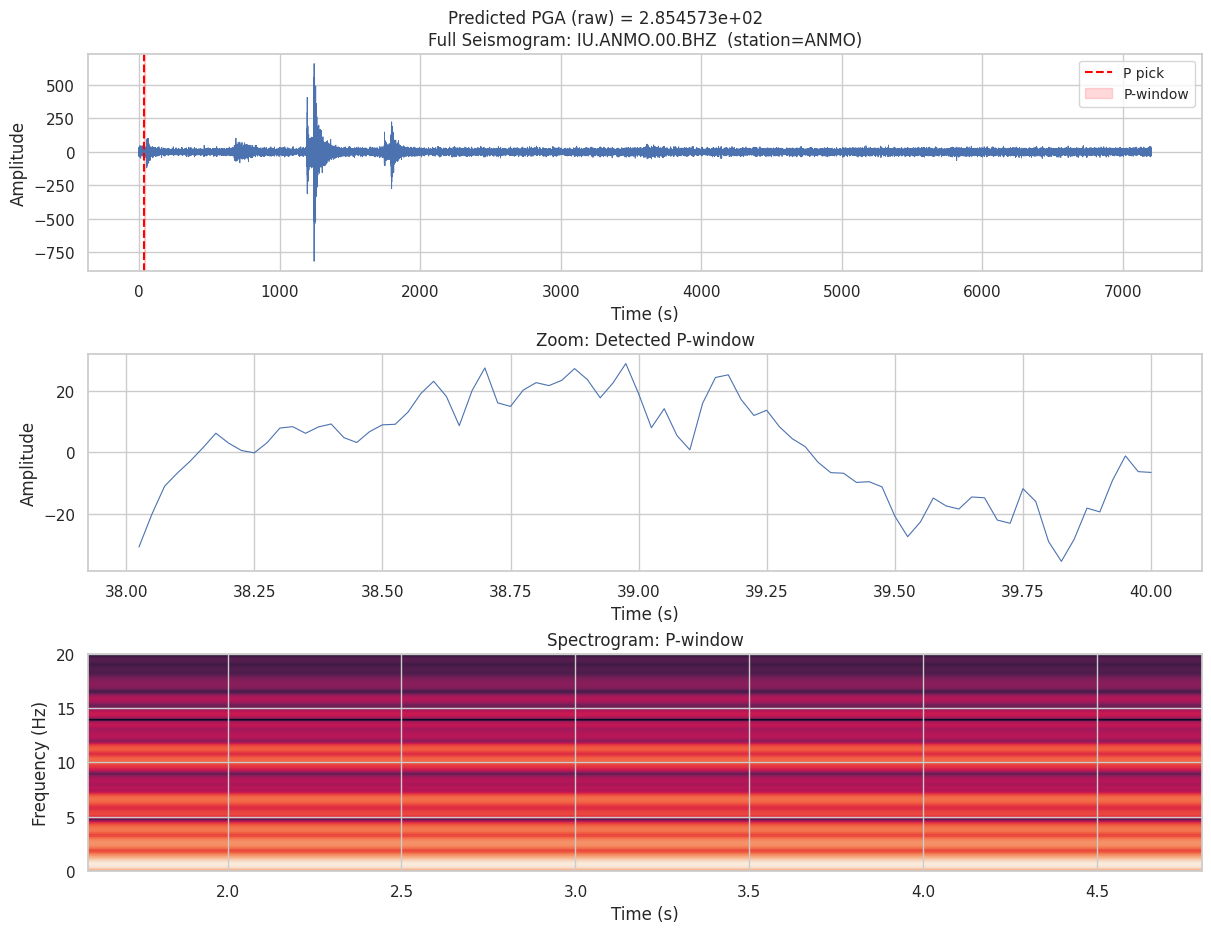

✅ Single-sample prediction saved to /content/single_sample_prediction.csv
✅ Visualization saved to /content/single_sample_prediction.png


,feature,value
0,pkev12,270.406
1,pkev23,14.0372
2,durP,2
3,tauPd,0.0310831
4,tauPt,0.069175
5,PDd,64.3436
6,PVd,470.626
7,PAd,14.0372
8,PDt,28.9122
9,PVt,470.626


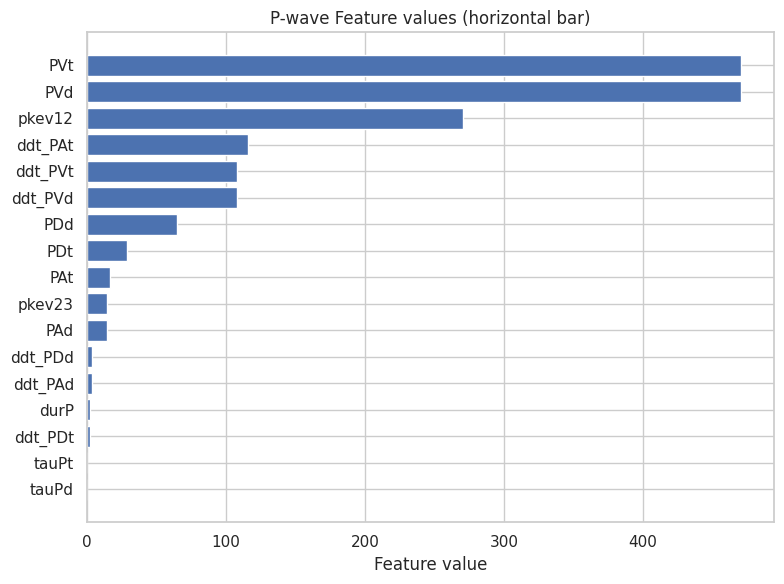

In [11]:
# Cell 8/11 — Fetch ONE random seismogram, extract P-window features, predict, and visualize
client = Client("IRIS")

def p_wave_features_calc(window: np.ndarray, dt: float) -> dict:
    # same function used during training — keep identical
    if len(window) == 0:
        return {k: np.nan for k in p_wave_features}
    durP = len(window) * dt
    PDd = np.max(window) - np.min(window)
    grad = np.gradient(window) / dt
    PVd = np.max(np.abs(grad)) if len(grad) > 0 else 0
    PAd = np.mean(np.abs(window))
    PDt = np.max(window)
    PVt = np.max(grad) if len(grad) > 0 else 0
    PAt = np.sqrt(np.mean(window ** 2))
    tauPd = durP / PDd if PDd != 0 else 0
    tauPt = durP / PDt if PDt != 0 else 0
    ddt = lambda x: np.mean(np.abs(np.gradient(x))) if len(x) > 1 else 0
    ddt_PDd = ddt(window)
    ddt_PVd = ddt(grad)
    ddt_PAd = ddt(np.abs(window))
    ddt_PDt = ddt(np.maximum(window, 0))
    ddt_PVt = ddt(grad)
    ddt_PAt = ddt(window ** 2)
    pkev12 = np.sum(window ** 2) / len(window)
    pkev23 = np.sum(np.abs(window)) / len(window)
    return {
        "pkev12": pkev12, "pkev23": pkev23,
        "durP": durP, "tauPd": tauPd, "tauPt": tauPt,
        "PDd": PDd, "PVd": PVd, "PAd": PAd,
        "PDt": PDt, "PVt": PVt, "PAt": PAt,
        "ddt_PDd": ddt_PDd, "ddt_PVd": ddt_PVd,
        "ddt_PAd": ddt_PAd, "ddt_PDt": ddt_PDt,
        "ddt_PVt": ddt_PVt, "ddt_PAt": ddt_PAt
    }

def fetch_single_seismogram(stations=None, net='IU', year_choices=[2022,2023,2024], max_attempts=8):
    if stations is None:
        stations = ["ANMO","COR","MAJO","KBL"]
    for attempt in range(max_attempts):
        try:
            yr = random.choice(year_choices)
            starttime = UTCDateTime(datetime.datetime(
                yr, random.randint(1,12), random.randint(1,25),
                random.randint(0,21), 0, 0
            ))
            endtime = starttime + 2*3600
            st = None
            for station in stations:
                try:
                    st = client.get_waveforms(net, station, "*", "BHZ", starttime, endtime)
                    if st and len(st) > 0:
                        break
                except Exception:
                    continue
            if st is None or len(st) == 0:
                continue
            tr = st[0].copy()
            tr.detrend("demean")
            tr.filter("bandpass", freqmin=0.5, freqmax=20.0)
            dt = tr.stats.delta
            cft = classic_sta_lta(tr.data, int(1/dt), int(10/dt))
            trig = trigger_onset(cft, 2.5, 1.0)
            if len(trig) == 0:
                continue
            p_index = int(trig[0][0])
            win = int(2.0 / dt)
            p_window = tr.data[p_index : p_index + win]
            if len(p_window) < 10:
                continue
            feats = p_wave_features_calc(p_window, dt)
            meta = {
                "station": tr.stats.station,
                "network": tr.stats.network,
                "starttime": str(starttime),
                "sampling_rate": tr.stats.sampling_rate,
                "p_index": p_index,
                "win_samples": len(p_window)
            }
            return {"trace": tr, "p_window": p_window, "p_index": p_index, "feats": feats, "meta": meta}
        except Exception:
            continue
    return None

# Fetch, predict, and visualize
sample = fetch_single_seismogram()
if sample is None:
    print("⚠️ Failed to fetch a valid seismogram sample. Try increasing max_attempts or change station list.")
else:
    tr = sample['trace']
    p_window = sample['p_window']
    p_index = sample['p_index']
    feats = sample['feats']
    meta = sample['meta']

    print("Sample fetched:")
    print("  station:", meta['station'])
    print("  network:", meta['network'])
    print("  requested starttime (window):", meta['starttime'])
    print("  sampling_rate:", meta['sampling_rate'])
    print("  p_index (sample):", meta['p_index'], "p-window samples:", meta['win_samples'])

    # Predict
    feats_df = pd.DataFrame([feats])
    sample_X = np.log1p(feats_df[p_wave_features].astype(float))
    sample_X_sel = selector.transform(imputer.transform(scaler.transform(sample_X)))
    pred_log = final_model.predict(sample_X_sel)[0]
    pred_pga = float(np.expm1(pred_log))

    # Save CSV row
    out = {**meta, **feats, 'pred_pga': pred_pga}
    pd.DataFrame([out]).to_csv('/content/single_sample_prediction.csv', index=False)

    # Visualize: full seismogram, P-window zoom, spectrogram
    t = np.arange(0, tr.stats.npts) * tr.stats.delta
    p_time = p_index * tr.stats.delta
    win_t = np.arange(0, len(p_window)) * tr.stats.delta + p_time

    fig, ax = plt.subplots(3, 1, figsize=(12, 9), constrained_layout=True)

    # Full seismogram
    ax[0].plot(t, tr.data, linewidth=0.6)
    ax[0].axvline(p_time, color='red', linestyle='--', label='P pick')
    ax[0].axvspan(p_time, p_time + len(p_window)*tr.stats.delta, alpha=0.15, color='red', label='P-window')
    ax[0].set_title(f"Full Seismogram: {tr.id}  (station={meta['station']})")
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Amplitude')
    ax[0].legend(loc='upper right', fontsize='small')

    # Zoom (P-window)
    ax[1].plot(win_t, p_window, linewidth=0.8)
    ax[1].set_title("Zoom: Detected P-window")
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Amplitude')

    # Spectrogram
    try:
        ax[2].specgram(p_window, NFFT=256, Fs=meta['sampling_rate'], noverlap=128)
        ax[2].set_title("Spectrogram: P-window")
        ax[2].set_xlabel('Time (s)')
        ax[2].set_ylabel('Frequency (Hz)')
    except Exception:
        freqs = np.fft.rfftfreq(len(p_window), d=1.0/meta['sampling_rate'])
        psd = np.abs(np.fft.rfft(p_window))**2
        ax[2].semilogy(freqs, psd)
        ax[2].set_title("FFT power (P-window)")
        ax[2].set_xlabel('Frequency (Hz)')
        ax[2].set_ylabel('Power')

    fig.suptitle(f"Predicted PGA (raw) = {pred_pga:.6e}", fontsize=12, y=1.02)
    figfile = '/content/single_sample_prediction.png'
    fig.savefig(figfile, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Single-sample prediction saved to /content/single_sample_prediction.csv")
    print(f"✅ Visualization saved to {figfile}")

    # Display features in a neat table + bar chart
    display(HTML("<h4>Extracted P-wave features (used for prediction)</h4>"))
    feat_table = feats_df.T.rename(columns={0:'value'}).reset_index().rename(columns={'index':'feature'})
    display(feat_table.style.format({'value':'{:.6g}'}))

    # Bar chart
    sorted_f = feat_table.assign(absval=feat_table['value'].abs()).sort_values('absval', ascending=True)
    plt.figure(figsize=(8,6))
    plt.barh(sorted_f['feature'], sorted_f['value'])
    plt.xlabel('Feature value')
    plt.title('P-wave Feature values (horizontal bar)')
    plt.tight_layout()
    plt.show()


In [14]:
# Cell 11/11 — Persist artifacts & print final summary
artifacts_dir = "/content/eew_artifacts"
os.makedirs(artifacts_dir, exist_ok=True)
joblib.dump(final_model, os.path.join(artifacts_dir, "xgb_eew_final.joblib"))
joblib.dump({'scaler': scaler, 'imputer': imputer, 'selector': selector, 'p_wave_features': p_wave_features}, os.path.join(artifacts_dir, "preproc_objects.joblib"))

# copy last CSV and figure into artifacts
if os.path.exists('/content/single_sample_prediction.csv'):
    os.replace('/content/single_sample_prediction.csv', os.path.join(artifacts_dir, "single_sample_prediction.csv"))
if os.path.exists('/content/single_sample_prediction.png'):
    os.replace('/content/single_sample_prediction.png', os.path.join(artifacts_dir, "single_sample_prediction.png"))

print("✅ All artifacts saved to:", artifacts_dir)
print("Notebook complete — the pipeline trained a final XGB (use your best_params), produced a single-sample prediction, visualizations, and a trigger analysis table.")


✅ All artifacts saved to: /content/eew_artifacts
Notebook complete — the pipeline trained a final XGB (use your best_params), produced a single-sample prediction, visualizations, and a trigger analysis table.


Feature,Value
pkev12,270.41
pkev23,14.037
durP,2
tauPd,0.031083
tauPt,0.069175
PDd,64.344
PVd,470.63
PAd,14.037
PDt,28.912
PVt,470.63

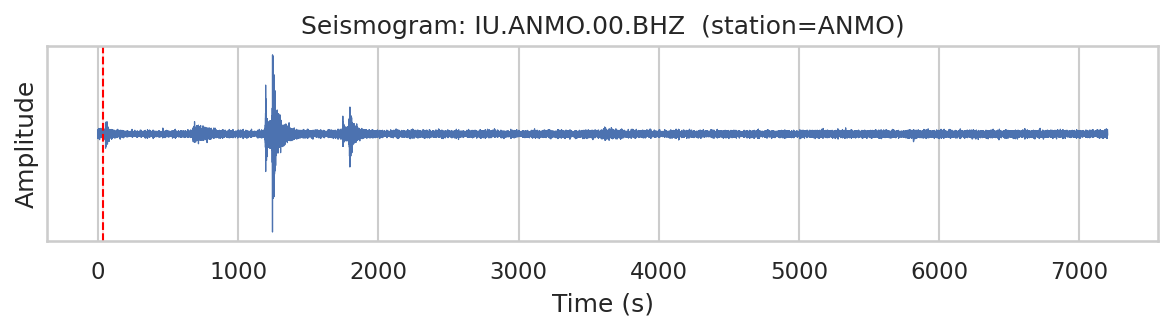
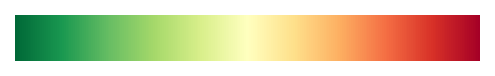

In [16]:
# Fixed Dashboard cell — builds CSV safely and embeds it in the HTML dashboard
import io, base64
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from IPython.display import HTML, display
from matplotlib import cm, colors
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

client = Client("IRIS")

def rgba_to_hex(rgba):
    return colors.to_hex(rgba)

def fig_to_base64(fig, dpi=150):
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=dpi, bbox_inches='tight')
    buf.seek(0)
    img_b64 = base64.b64encode(buf.read()).decode('ascii')
    plt.close(fig)
    return img_b64

# Ensure sample exists (try to fetch if not)
if 'sample' not in globals() or sample is None:
    try:
        sample = fetch_single_seismogram()  # helper from earlier cells
    except Exception as e:
        sample = None
        print("Could not find 'sample' and auto-fetch failed:", e)

if sample is None:
    raise RuntimeError("No sample available. Run the single-sample fetch & predict cell first (Cell 8).")

# Extract objects
tr = sample['trace']
p_window = sample['p_window']
meta = sample['meta']
feats = sample['feats']

# Predict (again if necessary)
feats_df = pd.DataFrame([feats])
sample_X = np.log1p(feats_df[p_wave_features].astype(float))
sample_X_sel = selector.transform(imputer.transform(scaler.transform(sample_X)))
pred_log = final_model.predict(sample_X_sel)[0]
pred_pga_raw = float(np.expm1(pred_log))  # cm/s^2
pred_pga_g = pred_pga_raw / 980.0

# Try to get station metadata
station_info = {}
try:
    query_start = UTCDateTime(meta['starttime']) if 'starttime' in meta else UTCDateTime.now()
    inv = client.get_stations(network=meta.get('network',''), station=meta.get('station',''),
                              level='station', starttime=query_start, endtime=query_start+1)
    if len(inv) > 0 and len(inv[0].stations) > 0:
        st = inv[0].stations[0]
        station_info['latitude'] = getattr(st, 'latitude', None)
        station_info['longitude'] = getattr(st, 'longitude', None)
        station_info['elevation_m'] = getattr(st, 'elevation', None)
except Exception:
    station_info = {}

# Color mapping
vmax_g = max(0.05, pred_pga_g*2, 0.2)
norm = colors.Normalize(vmin=0.0, vmax=vmax_g, clip=True)
cmap = cm.get_cmap('RdYlGn_r')
color_rgba = cmap(norm(pred_pga_g))
color_hex = rgba_to_hex(color_rgba)

# Make small seismogram thumbnail
dt = tr.stats.delta
t = np.arange(0, tr.stats.npts) * dt
p_time = meta.get('p_index', 0) * dt if 'p_index' in meta else 0
win_len = len(p_window)
win_t = np.arange(0, win_len) * dt + p_time

fig, ax = plt.subplots(figsize=(8,2.4))
ax.plot(t, tr.data, linewidth=0.6)
ax.axvline(p_time, color='red', linestyle='--', linewidth=1)
ax.axvspan(p_time, p_time + win_len*dt, color='red', alpha=0.12)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title(f"Seismogram: {tr.id}  (station={meta.get('station')})")
ax.set_yticks([])
plt.tight_layout()
seis_b64 = fig_to_base64(fig)

# small colorbar figure
fig2, ax2 = plt.subplots(figsize=(4,0.4))
cb = cm.ScalarMappable(norm=norm, cmap=cmap)
fig2.colorbar(cb, cax=ax2, orientation='horizontal', pad=0.01, label='PGA (g)')
ax2.set_axis_off()
cbar_b64 = fig_to_base64(fig2)

# Prepare feature table HTML (string formatted)
feat_df = pd.DataFrame([feats]).T.reset_index().rename(columns={'index':'feature', 0:'value'})
feat_df['value_str'] = feat_df['value'].apply(lambda x: f"{x:.5g}")

# Build CSV for download safely (outside f-string)
payload = {**meta, **feats, 'pred_pga_cm_s2': pred_pga_raw, 'pred_pga_g': pred_pga_g}
csv_bytes = pd.DataFrame([payload]).to_csv(index=False).encode()
csv_b64 = base64.b64encode(csv_bytes).decode()

# Build HTML
html = f"""
<div style="font-family: Arial, sans-serif; max-width:1000px; margin:12px auto; border:1px solid #ddd; border-radius:8px; padding:14px;">
  <div style="display:flex; align-items:center; justify-content:space-between;">
    <div style="flex:1;">
      <h2 style="margin:0 0 6px 0;">EEW Single-sample Prediction</h2>
      <div style="color:#444; margin-bottom:6px;">Station: <strong>{meta.get('station')}</strong> &nbsp; | &nbsp; Network: <strong>{meta.get('network')}</strong></div>
      <div style="color:#666; font-size:0.95rem;">Requested window starttime: <strong>{meta.get('starttime')}</strong> &nbsp; | &nbsp; Sampling rate: <strong>{meta.get('sampling_rate')} Hz</strong></div>
"""

if station_info.get('latitude') is not None and station_info.get('longitude') is not None:
    html += f"<div style='color:#666; font-size:0.95rem; margin-top:6px;'>Station location: <strong>{station_info['latitude']:.4f}°, {station_info['longitude']:.4f}°</strong></div>"

html += f"""
    </div>
    <div style="width:320px; text-align:center; padding:8px; border-radius:8px; background:{color_hex}; color:#111;">
      <div style="font-size:0.9rem; color:rgba(0,0,0,0.75);">Predicted PGA</div>
      <div style="font-weight:700; font-size:28px; margin:6px 0;">{pred_pga_raw:.5g} cm/s²</div>
      <div style="font-size:16px; font-weight:600; margin-bottom:6px;">{pred_pga_g:.5g} g</div>
      <div style="font-size:12px; color:rgba(0,0,0,0.65);">(converted: raw units ÷ 980 = g)</div>
    </div>
  </div>

  <hr style="margin:12px 0; border:none; border-top:1px solid #eee;" />

  <div style="display:flex; gap:14px;">
    <div style="flex: 1 1 420px; min-width:260px;">
      <img src="data:image/png;base64,{seis_b64}" style="width:100%; border-radius:6px; border:1px solid #eee;" />
      <div style="margin-top:8px;">
        <img src="data:image/png;base64,{cbar_b64}" style="width:220px;" />
      </div>
    </div>

    <div style="flex: 1 1 420px; min-width:260px;">
      <h4 style="margin:4px 0;">Extracted P-wave Features</h4>
      <div style="max-height:300px; overflow:auto; border:1px solid #f1f1f1; padding:8px; border-radius:6px; background:#fafafa;">
        <table style="width:100%; border-collapse:collapse; font-size:13px;">
          <thead><tr><th style="text-align:left; padding:6px 8px; color:#333;">Feature</th><th style="text-align:right; padding:6px 8px; color:#333;">Value</th></tr></thead>
          <tbody>
"""

for _, row in feat_df.iterrows():
    html += f"<tr><td style='padding:6px 8px; border-top:1px solid #fff'>{row['feature']}</td><td style='padding:6px 8px; text-align:right; border-top:1px solid #fff'>{row['value_str']}</td></tr>"

html += f"""
          </tbody>
        </table>
      </div>

      <div style="margin-top:10px; display:flex; gap:8px; align-items:center;">
        <a download="single_sample_prediction.csv" href="data:text/csv;base64,{csv_b64}" style="text-decoration:none; background:#2b7cff; color:white; padding:8px 12px; border-radius:6px;">Download CSV</a>
        <a href="#" style="text-decoration:none; background:#eee; color:#333; padding:8px 12px; border-radius:6px;">Inspect waveform</a>
      </div>
    </div>
  </div>

  <div style="margin-top:12px; color:#777; font-size:12px;">
    <strong>Legend:</strong> color scales from green (low) → yellow (moderate) → red (high). vmax used to normalize color: {vmax_g:.4g} g.
  </div>
</div>
"""

display(HTML(html))


In [18]:
# Enhanced dashboard additions: discrete intensity classes + folium map with legend
# Run after you've run the single-sample fetch+predict cell (Cell 8) and the dashboard cell.
!pip install --quiet folium

import folium, base64, io
from folium import IFrame
from IPython.display import display, HTML
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

client = Client("IRIS")

# --- Safety checks & re-compute prediction if necessary ---
if 'sample' not in globals() or sample is None:
    try:
        sample = fetch_single_seismogram()
    except Exception as e:
        raise RuntimeError("No sample in memory and auto-fetch failed: " + str(e))

tr = sample['trace']
meta = sample['meta']
feats = sample['feats']

# If pred_pga_raw / pred_pga_g not in memory, compute it
try:
    pred_pga_raw  # noqa: F821
    pred_pga_g
except NameError:
    feats_df = pd.DataFrame([feats])
    sample_X = np.log1p(feats_df[p_wave_features].astype(float))
    sample_X_sel = selector.transform(imputer.transform(scaler.transform(sample_X)))
    pred_log = final_model.predict(sample_X_sel)[0]
    pred_pga_raw = float(np.expm1(pred_log))
    pred_pga_g = pred_pga_raw / 980.0

# --- Discrete intensity classes (in g) and colors ---
# Thresholds chosen to be sensible for PGA in g given dataset range; adapt if you prefer.
intensity_bins = [
    (0.000, 0.005, 'Very Weak', '#2ca02c'),   # green
    (0.005, 0.020, 'Weak', '#ffdd57'),        # yellow
    (0.020, 0.050, 'Moderate', '#ff7f0e'),    # orange
    (0.050, 0.100, 'Strong', '#d62728'),      # red
    (0.100, 10.000, 'Very Strong', '#7f3b8b') # purple
]

def classify_intensity(g_val):
    for lo, hi, name, col in intensity_bins:
        if lo <= g_val < hi:
            return name, col
    return 'Extreme', '#000000'

intensity_name, intensity_color = classify_intensity(pred_pga_g)

# --- Station coordinates (try to fetch if not present) ---
station_lat = None
station_lon = None
try:
    if 'station_info' in globals() and station_info.get('latitude') is not None:
        station_lat = station_info.get('latitude')
        station_lon = station_info.get('longitude')
    else:
        # re-query IRIS station metadata near the sample time
        query_start = UTCDateTime(meta['starttime']) if 'starttime' in meta else UTCDateTime.now()
        inv = client.get_stations(network=meta.get('network',''), station=meta.get('station',''),
                                  level='station', starttime=query_start, endtime=query_start+1)
        if len(inv) > 0 and len(inv[0].stations) > 0:
            st = inv[0].stations[0]
            station_lat = getattr(st, 'latitude', None)
            station_lon = getattr(st, 'longitude', None)
except Exception:
    station_lat = station_lat
    station_lon = station_lon

# If still no coords, provide fallback and show message
if station_lat is None or station_lon is None:
    display(HTML("<div style='color:orange'><strong>Warning:</strong> station latitude/longitude not available. Map will show a global view. Try re-running station metadata lookup or use a different station.</div>"))

# --- Create folium map centered on station or default world view ---
if station_lat is None or station_lon is None:
    map_center = [0, 0]
    zoom = 2
else:
    map_center = [station_lat, station_lon]
    zoom = 6

m = folium.Map(location=map_center, zoom_start=zoom, tiles='CartoDB positron')

# Marker popup (HTML) including download link (use local CSV if exists)
popup_html = f"""
<h4>Station: {meta.get('station')} ({meta.get('network')})</h4>
<ul style="margin:0; padding-left:18px;">
  <li><strong>Requested window:</strong> {meta.get('starttime')}</li>
  <li><strong>Sampling rate:</strong> {meta.get('sampling_rate')} Hz</li>
  <li><strong>Predicted PGA:</strong> {pred_pga_raw:.5g} cm/s² ({pred_pga_g:.5g} g)</li>
  <li><strong>Intensity class:</strong> <span style="color:{intensity_color}; font-weight:700">{intensity_name}</span></li>
</ul>
"""
# CSV download: if file exists at /content/single_sample_prediction.csv, add link; otherwise embed data URI
csv_link_html = ""
csv_path = '/content/single_sample_prediction.csv'
if os.path.exists(csv_path):
    # Use relative link (Colab will let you download)
    csv_link_html = f'<a href="files{csv_path}" target="_blank" style="text-decoration:none">Download CSV</a>'
else:
    # embed CSV as data URI using csv_b64 if available
    try:
        csv_b64  # noqa: F821
        csv_link_html = f'<a download="single_sample_prediction.csv" href="data:text/csv;base64,{csv_b64}" style="text-decoration:none">Download CSV</a>'
    except NameError:
        # build CSV on the fly
        csv_bytes = pd.DataFrame([{**meta, **feats, 'pred_pga_cm_s2': pred_pga_raw, 'pred_pga_g': pred_pga_g}]).to_csv(index=False).encode()
        csv_b64_local = base64.b64encode(csv_bytes).decode()
        csv_link_html = f'<a download="single_sample_prediction.csv" href="data:text/csv;base64,{csv_b64_local}" style="text-decoration:none">Download CSV</a>'

popup_html += f"<div style='margin-top:6px'>{csv_link_html}</div>"

# Build a small HTML iframe for popup (limit size)
iframe = IFrame(html=popup_html, width=320, height=200)

# Marker color & circle radius scaling (radius in meters)
circle_radius_m = max(5000, min(80000, pred_pga_g * 200000))  # scale: tune as needed
marker_icon = folium.Icon(color='white', icon_color=intensity_color.replace('#',''), icon='info-sign')

if station_lat is None or station_lon is None:
    # add marker at map center
    folium.Marker(location=map_center, popup=iframe, tooltip=f"{meta.get('station')}", icon=folium.Icon(color='lightgray')).add_to(m)
else:
    folium.CircleMarker(
        location=[station_lat, station_lon],
        radius=12,
        color=intensity_color,
        fill=True,
        fill_color=intensity_color,
        fill_opacity=0.9,
        popup=iframe,
        tooltip=f"{meta.get('station')} - {intensity_name}"
    ).add_to(m)

    folium.Circle(
        location=[station_lat, station_lon],
        radius=circle_radius_m,
        color=intensity_color,
        fill=True,
        fill_opacity=0.18
    ).add_to(m)

# --- Add discrete legend to map ---
legend_html = """
<div style="
    position: fixed;
    bottom: 30px; left: 10px;
    width: 170px; height: auto;
    border:2px solid #444; z-index:9999; font-size:14px;
    background:white; padding:8px; border-radius:6px;
">
<b>Intensity classes (PGA in g)</b><br>
"""
for lo, hi, name, col in intensity_bins:
    if hi >= 10:
        rng = f">{lo:.3f}"
    else:
        rng = f"{lo:.3f} – {hi:.3f}"
    legend_html += f"<div style='display:flex; align-items:center; gap:8px; margin-top:6px;'><div style='width:18px; height:12px; background:{col}; border:1px solid #999;'></div><div style='flex:1'>{name} <small style='color:#555'>(~{rng} g)</small></div></div>"
legend_html += "</div>"

m.get_root().html.add_child(folium.Element(legend_html))

# Render the map (folium._repr_html_ returns HTML)
display(HTML("<h4>Interactive station map (click marker for details)</h4>"))
display(m)

# Also print a small HTML badge for the dashboard (discrete class)
badge_html = f"""
<div style="display:flex; gap:12px; align-items:center; margin-top:8px;">
  <div style="width:12px; height:12px; background:{intensity_color}; border-radius:3px; border:1px solid #333;"></div>
  <div>
    <div style="font-weight:700; font-size:15px;">{intensity_name}</div>
    <div style="color:#666; font-size:13px;">Predicted: {pred_pga_raw:.5g} cm/s² — {pred_pga_g:.5g} g</div>
  </div>
</div>
"""
display(HTML(badge_html))